In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc, warnings
import random
import datetime

from tqdm.notebook import tqdm
# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.offline as offline
# offline.init_notebook_mode()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

import lightgbm as lgb

import pickle

warnings.filterwarnings('ignore')
print("Test")

Test


In [8]:
path = 'E:/pasca/Documents/Test/'
# Input data files are available in the "../input/" directory.
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

E:/pasca/Documents/Test/building_metadata.csv
E:/pasca/Documents/Test/sample_submission.csv
E:/pasca/Documents/Test/test.csv
E:/pasca/Documents/Test/train.csv
E:/pasca/Documents/Test/weather_test.csv
E:/pasca/Documents/Test/weather_train.csv


In [9]:
# unimportant features (see importance below)
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source='train', path=path):
    ''' load and merge all tables '''
    assert source in ['train', 'test']
    
    building = pd.read_csv(f'{path}/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    weather  = pd.read_csv(f'{path}/weather_{source}.csv', parse_dates=['timestamp'],
                                                           dtype={'site_id':np.uint8, 'air_temperature':np.float16,
                                                                  'cloud_coverage':np.float16, 'dew_temperature':np.float16,
                                                                  'precip_depth_1_hr':np.float16},
                                                           usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'{path}/{source}.csv', dtype={'building_id':np.uint16, 'meter':np.uint8}, parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

Wall time: 18.4 s


<AxesSubplot:xlabel='primary_use'>

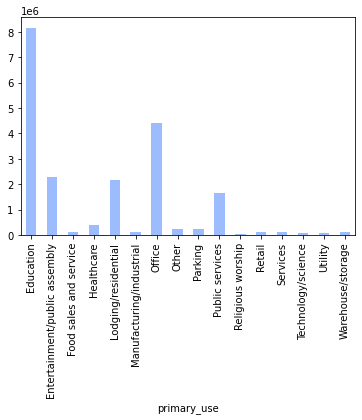

In [10]:
%%time
train = load_data('train')
train.sample(7)


groups = train.groupby('primary_use')['primary_use'].count()
groups.plot.bar(color='xkcd:lightish blue',alpha=0.5)

In [11]:
def missing_statistics(df):
    #show missing values
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [12]:
missing_statistics(train)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.00
1,meter,0,20216100,0.00
2,timestamp,0,20216100,0.00
3,meter_reading,0,20216100,0.00
4,site_id,0,20216100,0.00
5,primary_use,0,20216100,0.00
6,square_feet,0,20216100,0.00
7,year_built,12127645,20216100,59.99
8,floor_count,16709167,20216100,82.65
9,air_temperature,96658,20216100,0.48


<AxesSubplot:xlabel='building_id', ylabel='meter_reading'>

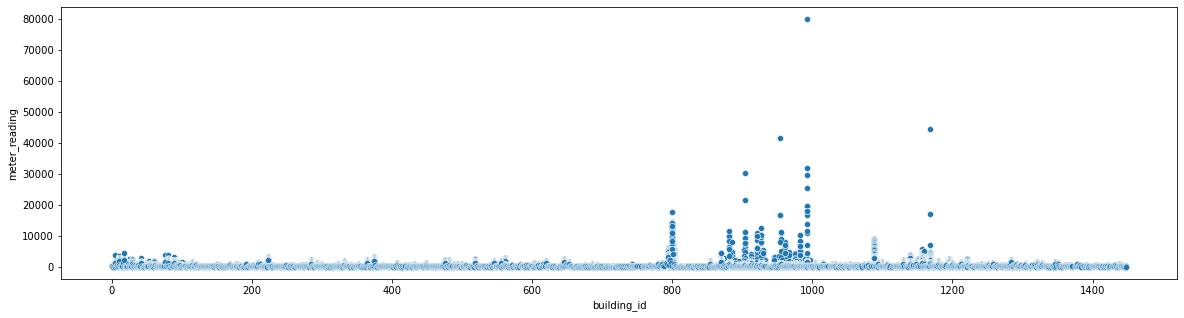

In [13]:
mask = train["meter"] == 0
train_2 = train[mask]
train_2.drop(["meter", "primary_use", "timestamp", "site_id", "square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"], axis = 1, inplace = True)
test = train_2.groupby("building_id").sum()
plt.figure(figsize=(20, 5))
sns.scatterplot(data = train_2, x = "building_id", y = "meter_reading")

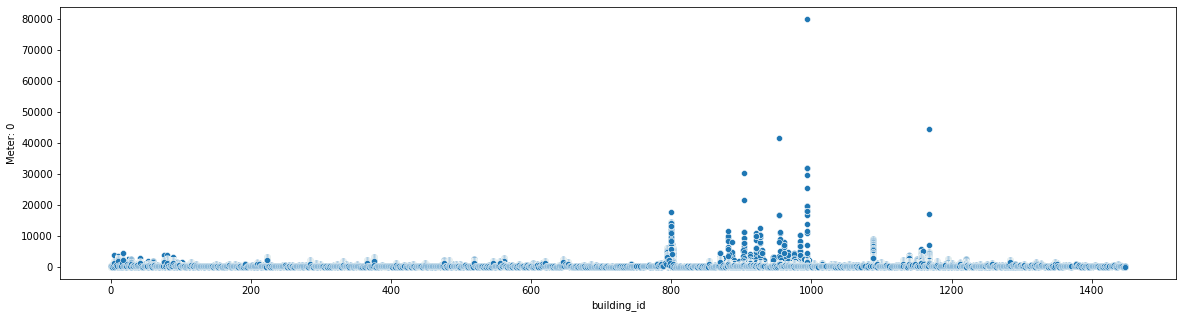

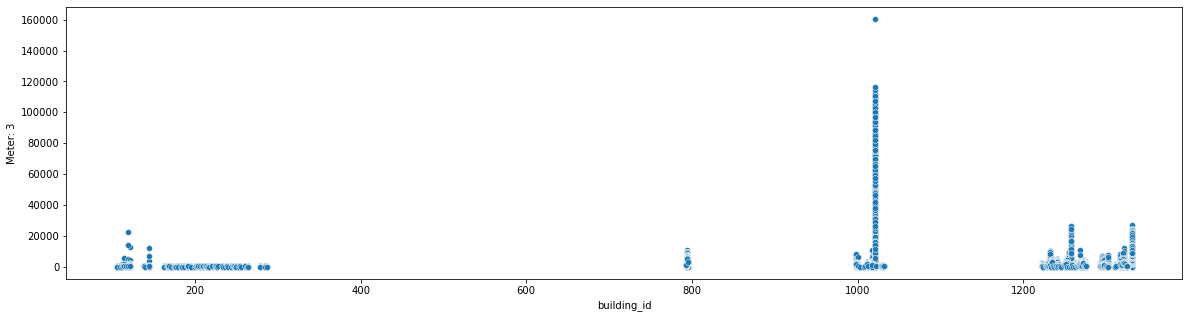

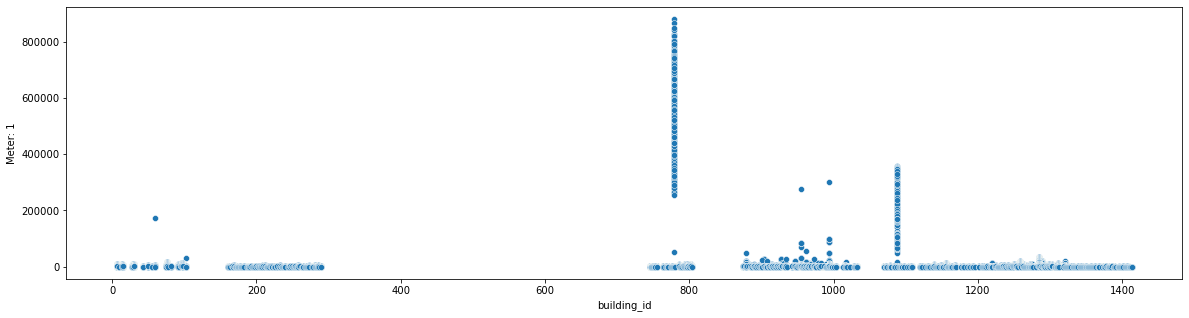

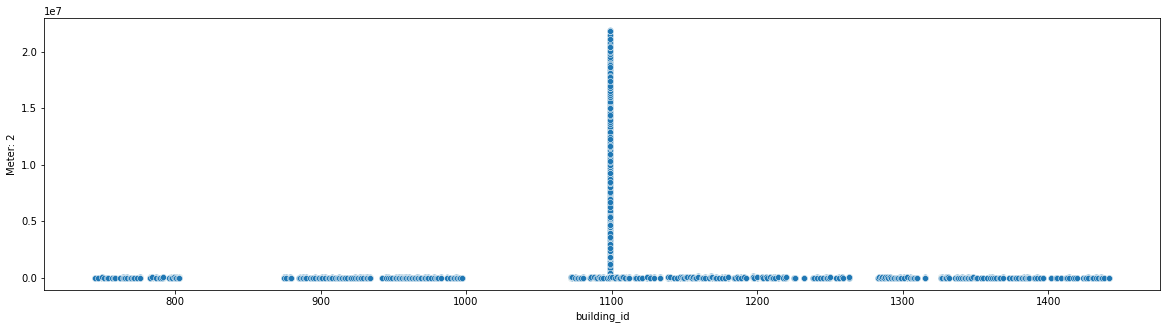

In [14]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    plt.figure(figsize=(20, 5))
    sns.scatterplot(data = train[mask], x = "building_id", y = "meter_reading")
    plt.ylabel("Meter: {}".format(meter))
    plt.show()

In [15]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr'],
      dtype='object')

<AxesSubplot:xlabel='building_id'>

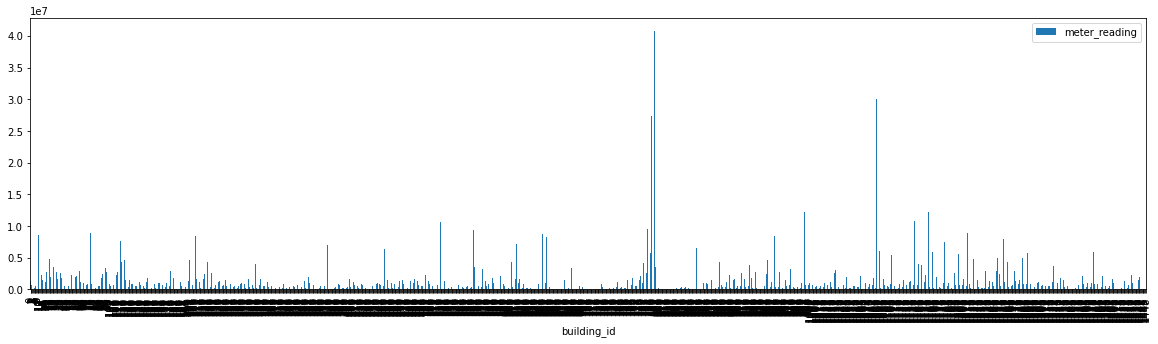

In [16]:
mask = train["meter"] == 0
train_1 = train[mask]
train_1.drop(["meter", "primary_use", "timestamp", "site_id", "square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"], axis = 1, inplace = True)
test = train_1.groupby("building_id").sum()
test.plot.bar(figsize=(20, 5))

<AxesSubplot:xlabel='building_id'>

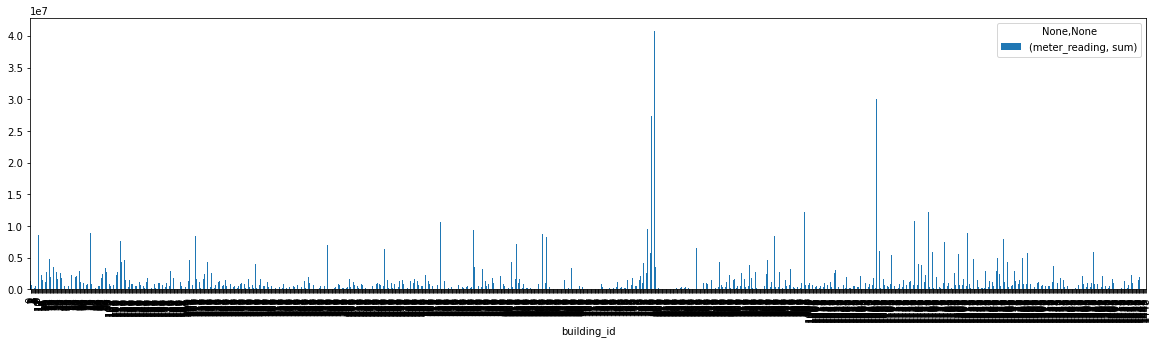

In [27]:
mask = train["meter"] == 0
train_2 = train[mask]
train_2.drop(["meter", "primary_use", "timestamp", "site_id", "square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"], axis = 1, inplace = True)
train_3 = train_2.groupby("building_id").agg([np.sum])
train_3.plot.bar(figsize=(20, 5))


<AxesSubplot:xlabel='meter'>

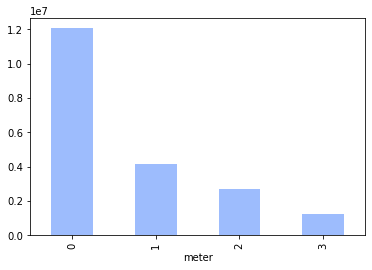

In [18]:
groups = train.groupby('meter')['meter'].count()
groups.plot.bar(color='xkcd:lightish blue',alpha=0.5)

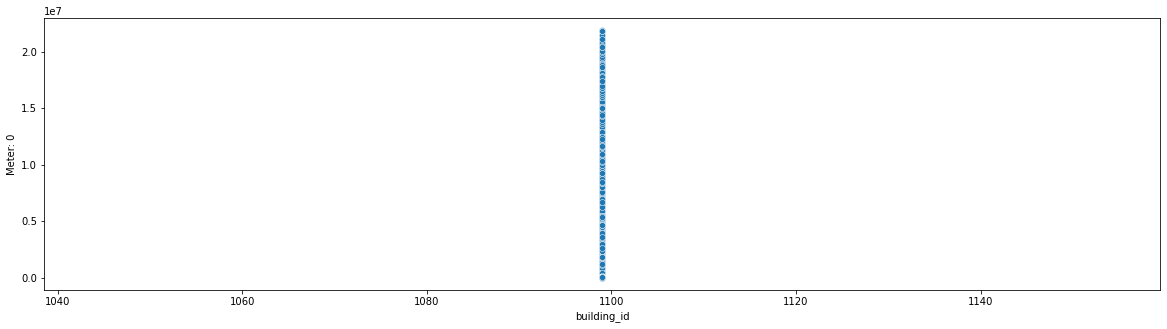

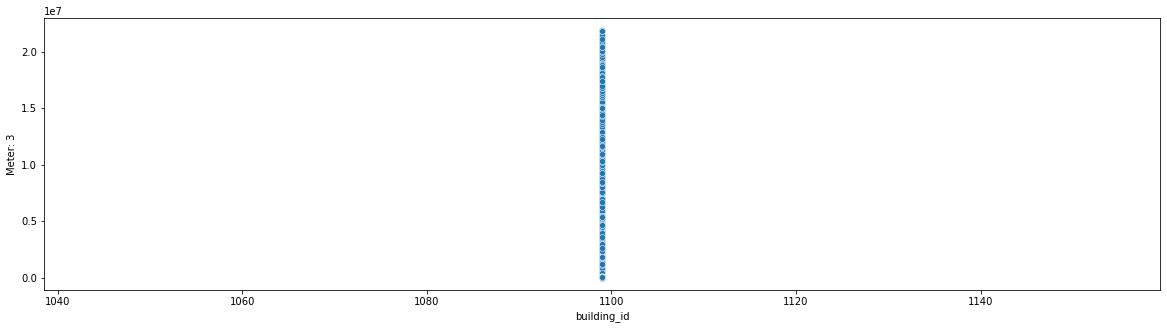

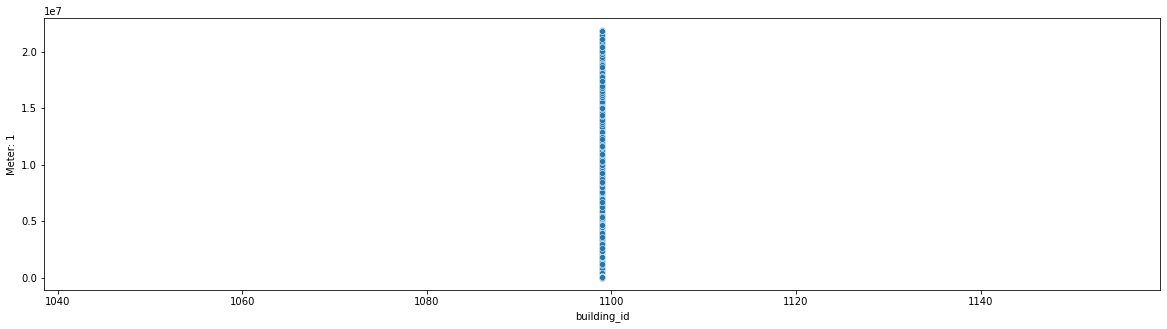

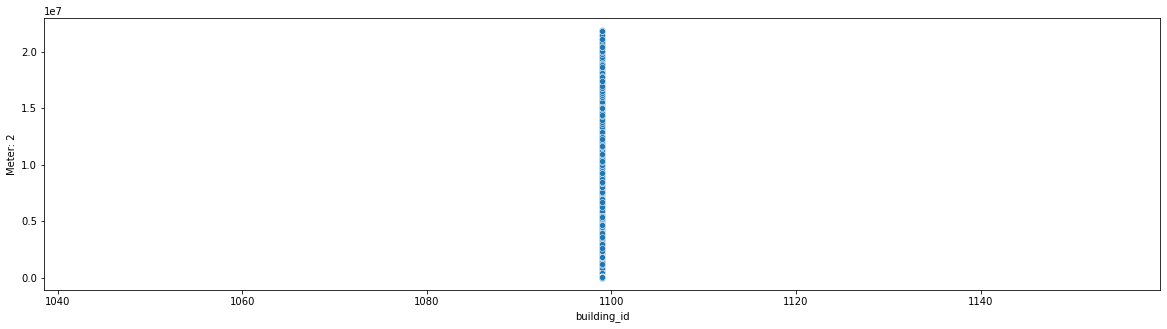

In [19]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    mask = train["building_id"] == 1099
    plt.figure(figsize=(20, 5))
    sns.scatterplot(data = train[mask], x = "building_id", y = "meter_reading")
    plt.ylabel("Meter: {}".format(meter))
    plt.show()

In [20]:
%%time
test = load_data('test')
test.sample(7)

Wall time: 33.7 s


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
17398717,17398717,773,0,2018-07-06 09:00:00,6,Lodging/residential,93313,NaN,NaN,24.406250,0.0,23.296875,0.0
39458640,39458640,1353,0,2018-01-22 18:00:00,15,Religious worship,22201,NaN,NaN,6.699219,NaN,5.601562,-1.0
39528842,39528842,1333,1,2018-02-03 12:00:00,15,Office,31316,1913.0,NaN,-11.703125,NaN,-15.601562,NaN
2981267,2981267,123,0,2018-04-23 07:00:00,1,Education,61204,1989.0,6.0,10.500000,0.0,7.500000,NaN
31691282,31691282,1142,1,2018-10-30 15:00:00,13,Office,103718,NaN,NaN,8.296875,NaN,5.000000,0.0
40857389,40857389,1353,0,2018-09-14 13:00:00,15,Religious worship,22201,NaN,NaN,21.703125,0.0,19.406250,NaN
14040706,14040706,618,0,2018-01-15 11:00:00,4,Education,148032,1924.0,5.0,7.199219,4.0,7.199219,0.0


In [21]:
print(f'Training from {train.timestamp.min()} to {train.timestamp.max()}')

Training from 2016-01-01 00:00:00 to 2016-12-31 23:00:00


In [22]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr'],
      dtype='object')

In [23]:
#train_1 = train["meter"] == 0
mask = train["meter"] == 0
train_1 = train[mask]
train_1.sample(5)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
11153504,713,0,2016-07-23 07:00:00,3.1880,5,Education,14973,1976.0,2.0,17.000000,NaN,15.000000,NaN
11560868,117,0,2016-07-30 15:00:00,58.1064,1,Education,15489,2004.0,4.0,22.000000,NaN,10.000000,NaN
20138487,233,0,2016-12-30 15:00:00,34.3900,2,Education,25139,1970.0,NaN,11.101562,NaN,5.601562,0.0
1987664,131,0,2016-02-06 01:00:00,189.5750,1,Lodging/residential,66661,1930.0,7.0,9.601562,NaN,8.500000,NaN
5082944,1000,0,2016-04-06 09:00:00,93.5000,10,Education,121146,NaN,2.0,2.800781,0.0,-4.398438,0.0


In [24]:
test_123 = plt.bar(train_1, x = "building_id"],y = "meter_reading")
test_123.show()

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (Temp/ipykernel_15052/1695494873.py, line 1)

In [ ]:
train_test = train["meter"] == 0
train_123 = train_test.groupby('building_id')['meter_reading'].sum()
plt.figure(figsize=(20, 5))
sns.scatterplot(data = train_test, x = "meter_reading", y = train_123)

In [ ]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    plt.figure(figsize=(20, 5))
    sns.scatterplot(data = train[mask], x = "meter_reading", y = "air_temperature")
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

In [ ]:
mask1 = train["meter"] == 0
mask2 = train["meter_reading"] > 40000
mask = np.logical_and(mask1, mask2)
print(train.shape)
train[mask]["meter_reading"] = np.mean(train[mask1]["meter_reading"])
print(train.shape)

In [ ]:
mask1 = train["meter"] == 3
mask2 = train["meter_reading"] > 140000
mask = np.logical_and(mask1, mask2)
print(train.shape)
train[mask]["meter_reading"] = np.mean(train[mask1]["meter_reading"])
print(train.shape)

In [ ]:
mask = train["building_id"] == 778
train[mask]["meter_reading"] = 1

In [ ]:
mask = train["building_id"] == 1088
train[mask]["meter_reading"] = 1

In [ ]:
# for our train and valudation dataset    return df
def correct_error_meter0_model_use(df):
    out = df
    new_values = out["meter_reading"] * 0.2931
    out.loc[out.meter == 0, "meter_reading"] = new_values
    return out

In [ ]:
# train = correct_error_meter0_model_use(train)

In [ ]:
# target's log-log histogram:
ax = train.meter_reading.hist()
ax.set_yscale('log')

# describe raw values first
train.meter_reading.describe()

In [ ]:
# check the distribution in the types of meters
meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}') # from the official starter kernel
_ = meters.hist()
# from the graphs it looks like steam and hotwater are reversed (e.g.: 3:steam, 2:hotwater) but that shouldn't make any difference to the model

In [ ]:
building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')

In [ ]:
meter = 1 # pick a meter

train_sample = train[(train['building_id'] == building_id) & (train['meter'] == meter)]  # same train sample as above

test['meter_reading'] = 0.0
test_sample = test[(test['building_id'] == building_id) & (test['meter'] == meter)]  # and the same meter in the test set

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Meter {meter}')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

# plot training sample
dates = matplotlib.dates.date2num(train_sample['timestamp'])
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature_train')

# plot test sample
dates = matplotlib.dates.date2num(test_sample['timestamp'])
ax2.plot_date(dates, test_sample['meter_reading'], '*', label='test', alpha=0.8)
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature_test')

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')

del train_sample; del test_sample; del dates

In [ ]:
# the counts above expose the missing data (Should we drop or refill the missing data?)
print("Ratio of available data (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

In [ ]:
# Is the same happening in the test set? Yes
print("Ratio of available data (not NAN's):")
test.count()/len(test)

In [ ]:
def ASHRAE3Preprocessor(df, data_ratios):
    avgs = df.loc[:,data_ratios < 1.0].mean()
    pu_le = LabelEncoder() # Asign to a categorical variable numerical values.
    pu_le.fit(df["primary_use"])
    
    df = df.fillna(avgs) # refill NAN with averages
    df['primary_use'] = np.uint8(pu_le.transform(df['primary_use']))  # encode labels

    # expand datetime into its components
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-2000)

    # parse and cast columns to a smaller type
#     df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
#     df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
    df['year_built'] = np.uint8(df['year_built']-1900)
    df['floor_count'] = np.uint8(df['floor_count'])

    # remove redundant columns
    for col in df.columns:
        if col in ['timestamp', 'row_id']:
            del df[col]

    # extract target column
    if 'meter_reading' in df.columns:
        df['meter_reading'] = np.log1p(df['meter_reading']/ df['square_feet']).astype(np.float32) # comp metric uses log errors 
    
    return df

In [ ]:
train_transform = ASHRAE3Preprocessor(train, data_ratios)

In [ ]:
train_transform.sample(7)

In [ ]:
%%time
fig, ax = plt.subplots(figsize=(16,8))
# use a ranked correlation to catch nonlinearities
# plot train in all columns except year, taking 100100 random samples, checking correlation using the method 'spearman'
corr = train_transform[[col for col in train_transform.columns if col != 'year']].sample(100100).corr(method='spearman')
_ = sns.heatmap(corr, annot=True,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

In [ ]:
# target = meter_reading
# force the model to use the weather data instead of dates, to avoid overfitting to the past history
features = [col for col in train_transform.columns if col not in [target, 'year', 'month', 'day']]

In [ ]:
def fit_regressor(tr_idx, val_idx, features_arr, target_str):
    # train
    tr_x, tr_y = train_transform[features_arr].iloc[tr_idx], train_transform[target_str][tr_idx]
    # evaluating ("test")
    vl_x, vl_y = train_transform[features_arr].iloc[val_idx], train_transform[target_str][val_idx]
    print({'train_transform size':len(tr_x), 'eval size':len(vl_x)})

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    clf = lgb.LGBMRegressor(n_estimators=6000,
                            learning_rate=0.28,
                            feature_fraction=0.9,
                            subsample=0.2,  # batches of 20% of the data
                            subsample_freq=1,
                            num_leaves=20,
                            metric='rmse')
    # Metric: Root Mean Square Error (RMSE), it tells you how concentrated the data is around the line of best fit.
    clf.fit(tr_x, tr_y,
            eval_set=[(vl_x, vl_y)],
            early_stopping_rounds=50,
            verbose=200)
    return clf

In [ ]:
folds = 4
seed = 42
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed) # Provides train/test indices to split data in train/test sets.
# oof_pred = np.zeros(train_transform.shape[0])  # out of fold predictions
models = []

## generating 4 train/test pair of index_arrays, and analizing wich give the better results.
for tr_idx, val_idx in tqdm(kf.split(train_transform, train_transform['building_id']), total=folds): # train/test indices
    clf = fit_regressor(tr_idx, val_idx, features, target)
    models.append(clf)

gc.collect() # trigger a manual garbage collection process, cleans up a huge amount of objects.

In [ ]:
_ = lgb.plot_importance(models[1], importance_type='gain', figsize=(16,8))

In [ ]:
# calculate the mean feature importance, so that we can update 'unimportant_cols' above
feature_importance = np.mean([m._Booster.feature_importance(importance_type='gain') for m in models], axis=0)
sorted(zip(feature_importance, train_transform.columns), reverse=True)

In [ ]:
features = [col for col in train_transform.columns if col not in [target, 'year', 'month', 'day']]
tr_idx = np.random.randint(0, 1552000, 1000000)
tr_x, tr_y = train_transform[features].iloc[tr_idx], train_transform[target][tr_idx]

In [ ]:
dic = {"real": tr_y, "prediction": models[1].predict(tr_x)}
p_df = pd.DataFrame(data = dic)

In [ ]:
actual = p_df["real"].values
predicted = p_df["prediction"].values
mse = sklearn.metrics.mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
print(rmse)

In [ ]:
# the counts above expose the missing data (Should we drop or refill the missing data?)
print("Ratio of available data (not NAN's):")
data_ratios = test.count()/len(test)
data_ratios

In [ ]:
# load and pre-process test data
test_transform = ASHRAE3Preprocessor(test, data_ratios)
test_transform.sample(7)

In [ ]:
folds = 4
meter = 1 # pick a meter
building_id = 1258  # a building with all 4 meters
features = [col for col in train_transform.columns if col not in [target, 'year', 'month', 'day']]

def recover_timestamp(x):
    ''' reassemble timestamp using date components '''
    return datetime.datetime.strptime(f'{x.year}-{x.month}-{x.day} {x.hour}', '%y-%m-%d %H')

fig, ax = plt.subplots(figsize=(16,4))
plt.title(f'Building {building_id} Meter {meter} on all {folds} prediction folds')
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

train_sample = train_transform[(train_transform['building_id'] == building_id) & (train_transform['meter'] == meter)]  # same training sample as before
test_sample = test_transform[(test_transform['building_id'] == building_id) & (test_transform['meter'] == meter)]   # and the same meter in the test set

# plot training sample
dates = matplotlib.dates.date2num(train_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax2.plot_date(dates, train_sample['meter_reading'], '-', label='train', alpha=0.8)
ax.plot_date(dates, train_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature_train')


# plot prediction sample
dates = matplotlib.dates.date2num(test_sample[['year', 'month', 'day', 'hour']].apply(recover_timestamp, axis=1))
ax.plot_date(dates, test_sample['air_temperature'], '.', color='tab:cyan', label='air_temperature')
for i,model in enumerate(models):
    ax2.plot_date(dates, np.expm1(model.predict(test_sample[features])), '-', label=f'prediction{i}', alpha=0.4)

ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading (+prediction)')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
_ = plt.show()